In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml
import MySQLdb as mdb
# from definitions import DATABASE_CONFIG_DIR, INCOME_STATEMENT_DIR

## load stock info

In [2]:
with open('../../database/database_config/database.ymal') as f:
    db_config = yaml.load(f, Loader=yaml.FullLoader)
db = mdb.connect(host=db_config['db_host'], user=db_config['db_user'], passwd=db_config['db_pass'],
                 db=db_config['db_name'], use_unicode=True, charset="utf8")
# select stockId and ticker from table stock_info
table_name = 'stock_info'
column_list = ['stockId', 'ticker', 'IndustryGroup']
columns = ','.join(column_list)
req = """SELECT %s FROM %s WHERE sp500=TRUE """ % (columns, table_name)
get_stock_info_cursor = db.cursor()
get_stock_info_cursor.execute(req)
stock_info = get_stock_info_cursor.fetchall()
get_stock_info_cursor.close()

#create dataframe
df_stock_info = pd.DataFrame(stock_info, columns=column_list)

In [3]:
df_stock_info.head(5)

,stockId,ticker,IndustryGroup
0,11,PNR,Machinery
1,37,ALLE,Building Materials
2,45,ITW,Machinery
3,48,AMAT,Semiconductor Equip
4,52,NWL,Household Products


## load the file

In [4]:
file = '../20210321_valuation_result_sp500.csv'
df_valuation = pd.read_csv(file)

In [5]:
df_valuation.head(5)

,ticker,current_price,estimated_value,price_to_value
0,PNR,61.02,35.352727,1.726034
1,ALLE,119.92,80.469651,1.490251
2,ITW,218.69,154.809823,1.412636
3,AMAT,114.86,104.682096,1.097227
4,NWL,26.09,14.159187,1.842620


In [6]:
df_valuation.describe()

,current_price,estimated_value,price_to_value
count,489.000000,487.000000,487.000000
mean,171.612035,-1717.212123,1.043718
std,297.240590,26572.823283,18.968509
min,11.020000,-460520.985894,-191.593746
25%,59.730000,20.055851,0.734154
50%,106.770000,65.095890,1.326223
75%,188.330000,126.368253,2.126902
max,4434.990000,16134.444236,174.252492


## merge two dataframes

In [7]:
df = pd.merge(df_valuation, df_stock_info, left_on='ticker', right_on='ticker', how='left')

In [8]:
## filter out finanace sector 
df = df.loc[(df['IndustryGroup']!='Financial Svcs. (Non-bank & Insurance)')
                 & (df['IndustryGroup']!='Banks (Regional)') 
                 & (df['IndustryGroup']!='Bank (Money Center)') 
                 & (df['IndustryGroup']!='Brokerage & Investment Banking') 
                 & (df['IndustryGroup']!='Investments & Asset Management') 
                 & (df['IndustryGroup']!='Insurance (Life)')
                 & (df['IndustryGroup']!='Insurance (Prop/Cas.)')
                 & (df['IndustryGroup']!='Insurance (General)')]

## EDA

array([[<AxesSubplot:title={'center':'price_to_value'}>]], dtype=object)

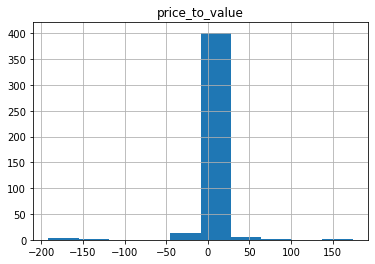

In [9]:
df.hist(column="price_to_value")

### calculate the range

In [10]:
def cut_to(x):
    if x<0:
        return 'less than 0'
    elif x<1:
        return '0-1'
    else:
        return 'larger than 1'

df['valuation_range'] = df['price_to_value'].map(cut_to)

In [11]:
df

,ticker,current_price,estimated_value,price_to_value,stockId,IndustryGroup,valuation_range
0,PNR,61.02,35.352727,1.726034,11,Machinery,larger than 1
1,ALLE,119.92,80.469651,1.490251,37,Building Materials,larger than 1
2,ITW,218.69,154.809823,1.412636,45,Machinery,larger than 1
3,AMAT,114.86,104.682096,1.097227,48,Semiconductor Equip,larger than 1
4,NWL,26.09,14.159187,1.842620,52,Household Products,larger than 1
...,...,...,...,...,...,...,...
500,UAL,60.77,-1594.061325,-0.038123,9772,Air Transport,less than 0
501,CDW,158.03,104.903001,1.506439,9829,Computer Services,larger than 1
502,MU,90.51,186.525600,0.485242,9839,Semiconductor,0-1
503,DLTR,108.12,117.833124,0.917569,9850,Retail (General),0-1


In [12]:
df['valuation_range'].value_counts()

larger than 1    308
0-1               70
less than 0       65
Name: valuation_range, dtype: int64

## sort

In [13]:
df.sort_values(by=['price_to_value'])

,ticker,current_price,estimated_value,price_to_value,stockId,IndustryGroup,valuation_range
125,HOLX,72.03,-0.375952,-191.593746,2317,Healthcare Products,less than 0
5,MAA,141.52,-0.821716,-172.224911,54,R.E.I.T.,less than 0
346,DD,77.10,-0.461416,-167.094412,6448,Chemical (Specialty),less than 0
89,REG,56.06,-0.422219,-132.774737,1651,R.E.I.T.,less than 0
12,GPN,205.47,-7.807617,-26.316609,149,Information Services,less than 0
...,...,...,...,...,...,...,...
342,BSX,38.17,NaN,NaN,6318,Healthcare Products,larger than 1
349,NWS,NaN,NaN,NaN,6468,empty,larger than 1
370,AMCR,NaN,NaN,NaN,6912,empty,larger than 1
401,GOOGL,NaN,NaN,NaN,7514,empty,larger than 1


### select the valuation between 0-1

In [14]:
df = df.loc[df['valuation_range'] == '0-1']
df = df.sort_values(by=['price_to_value'])

array([[<AxesSubplot:title={'center':'price_to_value'}>]], dtype=object)

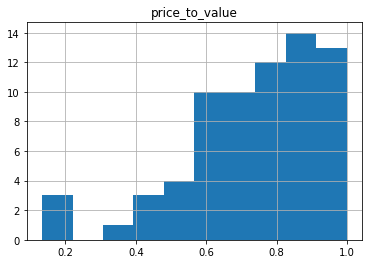

In [15]:
df.hist(column="price_to_value")

In [16]:
df.head(10)

,ticker,current_price,estimated_value,price_to_value,stockId,IndustryGroup,valuation_range
138,HLT,124.390,928.581609,0.133957,2632,Hotel/Gaming,0-1
58,BKNG,2287.740,16134.444236,0.141792,1196,Retail (Online),0-1
14,MAR,152.280,1036.427525,0.146928,151,Hotel/Gaming,0-1
431,RL,121.750,338.938647,0.359210,8292,Apparel,0-1
362,DHI,83.630,186.927851,0.447392,6698,Homebuilding,0-1
275,FOXA,42.925,92.944763,0.461833,5061,Broadcasting,0-1
53,PHM,48.990,104.730680,0.467771,1120,Homebuilding,0-1
502,MU,90.510,186.525600,0.485242,9839,Semiconductor,0-1
23,CI,243.260,492.525613,0.493903,344,Healthcare Support Services,0-1
259,MPC,53.760,98.512730,0.545716,4733,Oilfield Svcs/Equip.,0-1


In [17]:
df.loc[(df['price_to_value']>0.6) & (df['price_to_value']<0.8)]

,ticker,current_price,estimated_value,price_to_value,stockId,IndustryGroup,valuation_range
251,MCK,189.77,315.815470,0.600889,4654,Healthcare Support Services,0-1
479,DXC,28.03,46.492635,0.602891,9425,Computer Services,0-1
137,LB,60.54,98.899051,0.612139,2566,Retail (Special Lines),0-1
140,ABC,115.92,186.629958,0.621122,2669,Healthcare Support Services,0-1
35,HII,197.26,314.914734,0.626392,680,Aerospace/Defense,0-1
334,IPG,29.59,46.785842,0.632456,6158,Advertising,0-1
237,HUM,409.82,646.948582,0.633466,4408,Healthcare Support Services,0-1
296,PCAR,95.06,148.932156,0.638277,5402,Construction Supplies,0-1
485,LYB,106.77,165.582364,0.644815,9481,Chemical (Basic),0-1
247,UHS,138.00,213.589540,0.646099,4630,Hospitals/Healthcare Facilities,0-1
